In [30]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
import os
from scipy.stats import spearmanr, entropy

sns.set_style('white')
sns.set_context('notebook')

In [28]:
SAVE_FIGURES=True
DROP_UNCONVERGED=True

## NN

In [3]:
def load_preprocess_relu(algo, dataset, tag=""):
    # Read
    df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_results{tag}.csv')

    if DROP_UNCONVERGED:
        df.drop(df[df['train_01_error'] == 0.5].index, inplace=True)

    # Define headers
    metric = "01_error"
    train_error = f'train_{metric}'
    test_error = f'test_{metric}'
    # Set to floats
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            pass
    # Create new metrics/columns
    df['generalization_gap'] = df[test_error] - df[train_error]
    df['IRM_L1'] = df['IRM_L1'] / df['n_train_samples']
    df['n_regions'] = df['n_regions'] / df['n_train_samples']
    
    return df

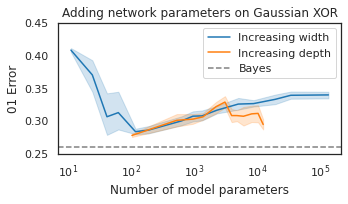

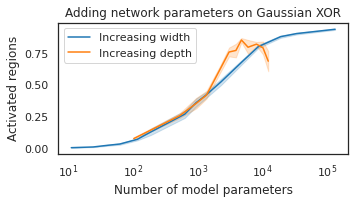

In [62]:
dataset = "xor"
x_var = 'n_parameters'
x_label = 'Number of model parameters'

for metric, ylab, ylim in [('01_error', '01 Error', 0.45)]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
    train_error = f'train_{metric}'
    test_error = f'test_{metric}'
    # ax.axvline(2*df['n_train_samples'].iloc[0], ls='--', c='grey')

    for algo, label in [
        ('wide_relu', 'Increasing width'),
        ('deep_relu', 'Increasing depth'),
    ]:
        df = load_preprocess_relu(algo, dataset)
        sns.lineplot(
            data=df, x=x_var, y=test_error,
            ax=ax, label=label)

    ax.axhline(0.26, ls='--', label='Bayes', c='grey')
    plt.xscale('log')
    plt.ylabel(ylab)
    plt.xlabel(x_label)
    plt.legend()
    plt.ylim([0.25, ylim])
    plt.title('Adding network parameters on Gaussian XOR')
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(f'./figures/relus_{dataset}_test_{metric}_vs_param.pdf')
    plt.show()
    
for metric, ylab in [('n_regions', 'Activated regions')]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
    # ax.axvline(2*df['n_train_samples'].iloc[0], ls='--', c='grey')

    for algo, label in [
        ('wide_relu', 'Increasing width'),
        ('deep_relu', 'Increasing depth'),
    ]:
        df = load_preprocess_relu(algo, dataset)
        sns.lineplot(
            data=df, x=x_var, y=metric,
            ax=ax, label=label)

    plt.xscale('log')
    plt.ylabel(ylab)
    plt.xlabel(x_label)
    plt.title('Adding network parameters on Gaussian XOR')
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(f'./figures/relus_{dataset}_{metric}_vs_param.pdf')
    plt.show()

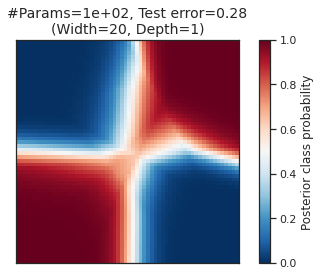

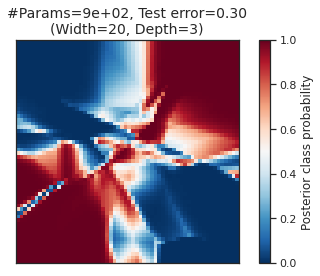

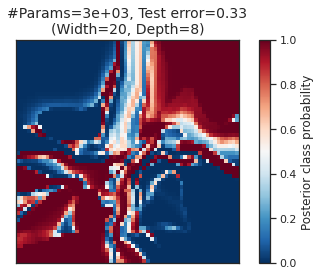

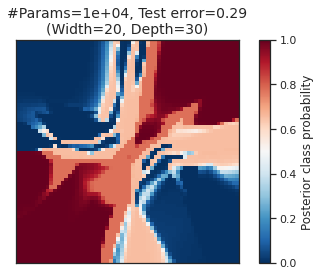

In [34]:
dataset = "xor"
algo = "deep_relu"
df = load_preprocess_relu(algo, dataset)

xx, yy = np.meshgrid(
        np.arange(-3, 3, 0.1),
        np.arange(-3, 3, 0.1))


param_key = 'n_parameters'
# for el in df[param_key].unique():
for el in [102, 942, 3042, 12282]:
    width, depth, err = df[df[param_key].astype(int) == el].mean()[['width', 'depth', 'test_01_error']]
    indices = df[df[param_key] == el].index
    
    avg_posteriors = np.zeros(xx.shape)
    for i in indices:
        Z = np.load(f'./varying_model_results/{dataset}/{dataset}_{algo}_posteriors/posterior_map_{i}.npy')
        avg_posteriors += Z / len(indices)
        
    # plt.figure(figsize=(3, 3))
    plt.imshow(Z, vmin=0, vmax=1, cmap='RdBu_r')
    cbar = plt.colorbar()
    cbar.set_label('Posterior class probability')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'#Params={el:.0e}, Test error={err:.2f}\n(Width={int(width)}, Depth={int(depth)})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'./figures/posterior_plots/{dataset}_{algo}_{int(depth)}.pdf', bbox_inches='tight')
    plt.show()

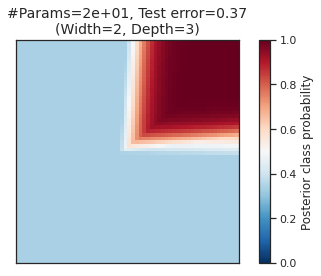

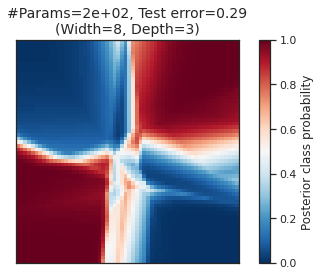

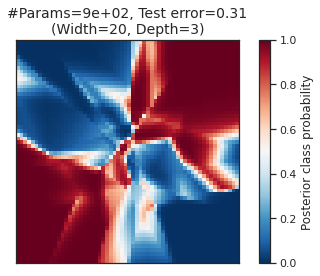

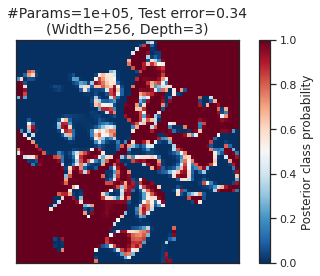

In [35]:
dataset = "xor"
algo = "wide_relu"
df = load_preprocess_relu(algo, dataset)

xx, yy = np.meshgrid(
        np.arange(-3, 3, 0.1),
        np.arange(-3, 3, 0.1))


param_key = 'n_parameters'
# for el in df[param_key].unique():
for el in [24, 186, 942, 132866]:  
    width, depth, err = df[df[param_key].astype(int) == el].mean()[['width', 'depth', 'test_01_error']]
    indices = df[df[param_key] == el].index
    
    avg_posteriors = np.zeros(xx.shape)
    for i in indices:
        Z = np.load(f'./varying_model_results/{dataset}/{dataset}_{algo}_posteriors/posterior_map_{i}.npy')
        avg_posteriors += Z / len(indices)
        
    # plt.figure(figsize=(7, 6))
    plt.imshow(Z, vmin=0, vmax=1, cmap='RdBu_r')
    cbar = plt.colorbar()
    cbar.set_label('Posterior class probability')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'#Params={el:.0e}, Test error={err:.2f}\n(Width={int(width)}, Depth={int(depth)})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'./figures/posterior_plots/{dataset}_{algo}_{int(width)}.pdf', bbox_inches='tight')
    plt.show()

## Forest

In [36]:
def load_preprocess_forest(algo, dataset, tag=""):
    # Read
    df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_results{tag}.csv')

    df.drop(df[df['max_depth'] == 'None'].index, inplace=True)

    # Define headers
    metric = "01_error"
    train_error = f'train_{metric}'
    test_error = f'test_{metric}'
    # Set to floats
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            pass

    for col in ['max_depth', 'n_total_leaves', 'n_regions']:
        df[col] = df[col].astype(int)

    # Create new metrics/columns
    df['generalization_gap'] = df[test_error] - df[train_error]
    df['IRM_L1'] = df['IRM_L1'] / df['n_train_samples']
    df['n_regions'] = df['n_regions'] / df['n_train_samples']

    min_est = df['n_estimators'].min()
    df_lookup = df[df['n_estimators'] == min_est].groupby('max_depth').mean()

    df['expected_leaves'] = df.apply(
        lambda row: df_lookup.loc[row['max_depth']]['n_total_leaves'] / min_est * row['n_estimators'],
        axis=1
    )
    
    return df

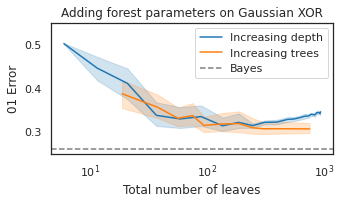

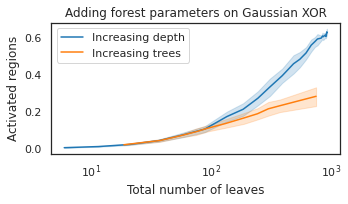

In [64]:
sns.set_context('notebook')

dataset = "xor"
x_var = 'expected_leaves'
x_label = 'Total number of leaves'

for metric, ylab, ylim in [('01_error', '01 Error', 0.55)]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
    train_error = f'train_{metric}'
    test_error = f'test_{metric}'
    # ax.axvline(2*df['n_train_samples'].iloc[0], ls='--', c='grey')

    for algo, label in [
        ('deep_forest', 'Increasing depth'),
        ('shallow_forest', 'Increasing trees')
    ]:
        df = load_preprocess_forest(algo, dataset)
        sns.lineplot(
            data=df, x=x_var, y=test_error,
            ax=ax, label=label)

    ax.axhline(0.26, ls='--', label='Bayes', c='grey')
    plt.xscale('log')
    plt.ylabel(ylab)
    plt.xlabel(x_label)
    plt.legend()
    plt.ylim([0.25, ylim])
    plt.title('Adding forest parameters on Gaussian XOR')
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(f'./figures/forests_{dataset}_test_{metric}_vs_param.pdf')
    plt.show()
    
for metric, ylab in [('n_regions', 'Activated regions')]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
    # ax.axvline(2*df['n_train_samples'].iloc[0], ls='--', c='grey')

    for algo, label in [
        ('deep_forest', 'Increasing depth'),
        ('shallow_forest', 'Increasing trees')
    ]:
        df = load_preprocess_forest(algo, dataset)
        sns.lineplot(
            data=df, x=x_var, y=metric,
            ax=ax, label=label)

    plt.xscale('log')
    plt.ylabel(ylab)
    plt.xlabel(x_label)
    plt.title('Adding forest parameters on Gaussian XOR')
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(f'./figures/forests_{dataset}_{metric}_vs_param.pdf')
    plt.show()

### Posteriors

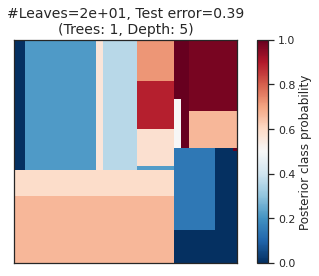

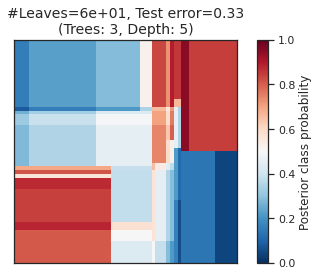

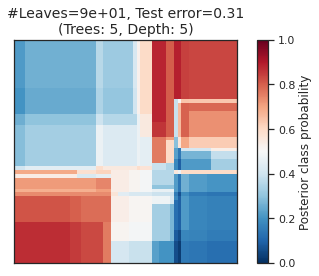

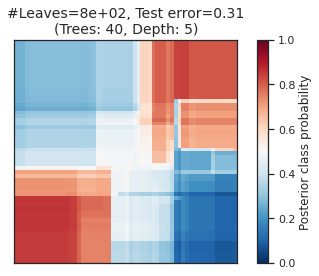

In [37]:
dataset = "xor"
algo = "shallow_forest"
df = load_preprocess_forest(algo, dataset)

xx, yy = np.meshgrid(
        np.arange(-3, 3, 0.1),
        np.arange(-3, 3, 0.1))


param_key = 'expected_leaves'
# for el in df[param_key].unique():
for el in [18, 56, 94, 754]:
    n_est, depth, err = df[df[param_key].astype(int) == el].mean()[['n_estimators', 'max_depth', 'test_01_error']]
    indices = df[df[param_key].astype(int) == el].index
    
    avg_posteriors = np.zeros(xx.shape)
    for i in indices:
        Z = np.load(f'./varying_model_results/{dataset}/{dataset}_{algo}_posteriors/posterior_map_{i}.npy')
        avg_posteriors += Z / len(indices)
        
    # plt.figure(figsize=(7, 6))
    plt.imshow(Z, vmin=0, vmax=1, cmap='RdBu_r')
    cbar = plt.colorbar()
    cbar.set_label('Posterior class probability')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'#Leaves={el:.0e}, Test error={err:.2f}\n(Trees: {int(n_est)}, Depth: {int(depth)})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'./figures/posterior_plots/{dataset}_{algo}_{int(n_est)}.pdf', bbox_inches='tight')
    plt.show()

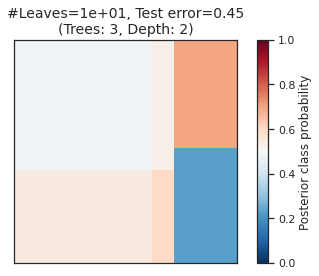

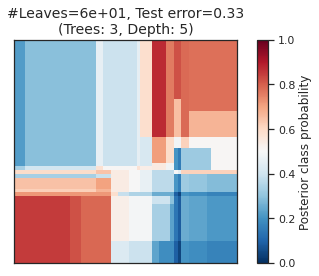

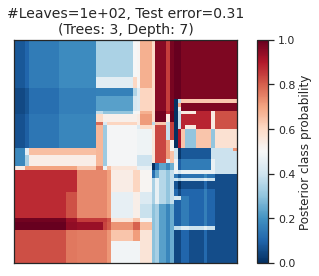

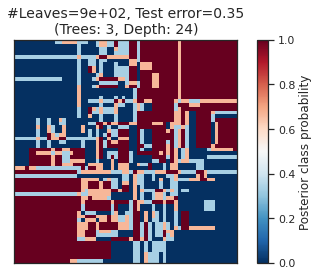

In [38]:
dataset = "xor"
algo = "deep_forest"
df = load_preprocess_forest(algo, dataset)

xx, yy = np.meshgrid(
        np.arange(-3, 3, 0.1),
        np.arange(-3, 3, 0.1))


param_key = 'expected_leaves'
# for el in df[param_key].unique():
for el in [11, 59, 136, 931]:
    n_est, depth, err = df[df[param_key].astype(int) == el].mean()[['n_estimators', 'max_depth', 'test_01_error']]
    indices = df[df[param_key].astype(int) == el].index
    
    avg_posteriors = np.zeros(xx.shape)
    for i in indices:
        Z = np.load(f'./varying_model_results/{dataset}/{dataset}_{algo}_posteriors/posterior_map_{i}.npy')
        avg_posteriors += Z / len(indices)
        
    # plt.figure(figsize=(7, 6))
    plt.imshow(Z, vmin=0, vmax=1, cmap='RdBu_r')
    cbar = plt.colorbar()
    cbar.set_label('Posterior class probability')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'#Leaves={el:.0e}, Test error={err:.2f}\n(Trees: {int(n_est)}, Depth: {int(depth)})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'./figures/posterior_plots/{dataset}_{algo}_{int(depth)}.pdf', bbox_inches='tight')
    plt.show()